<a href="https://colab.research.google.com/github/PritamGoyal/Speech-Recognition-and-Gender-prediction/blob/main/final_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub
!pip install SpeechRecognition pydub
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 42.6 MB/s eta 0:00:00


In [2]:
!pip install pyworld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyworld: filename=pyworld-0.3.4-cp310-cp310-linux_x86_64.whl size=865333 sha256=d712b91a9184aefe025ae5ff60d0680925b2c1b589e2bc13bf654dad7404bac9
  Stored in directory: /root/.cache/pip/wheels/66/09/8a/a1d79b73d59756f66e9bfe55a199840efc7473adb76ddacdfd
Successfully built pyworld


In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d mozillaorg/common-voice

Dataset URL: https://www.kaggle.com/datasets/mozillaorg/common-voice
License(s): CC0-1.0
100% 12.0G/12.0G [02:16<00:01, 15.7MB/s]
100% 12.0G/12.0G [02:16<00:00, 94.9MB/s]


In [6]:
!unzip /content/common-voice.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/cv-valid-train/cv-valid-train/sample-190776.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190777.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190778.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190779.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190780.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190781.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190782.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190783.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190784.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190785.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190786.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190787.mp3  
  inflating: /content/cv-valid-train/cv-valid-train/sample-190788.mp3  
  inflating: 

In [7]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import pickle

In [8]:
# Install necessary libraries
!pip install pyworld imbalanced-learn yellowbrick xgboost

In [9]:
# Specify the file path
file_path = '/content/cv-valid-train.csv'

# Read the CSV file into a DataFrame
dftrain = pd.read_csv(file_path)
dftrain.info()

# Drop rows where 'gender' column is null
dftrain = dftrain.dropna(subset=['gender'])
dftrain.info()
dftrain.head()

# Define the audio folder path
audio_folder_path = '/content/cv-valid-train/cv-valid-train'

# Extract two female and two male filenames from dftrain
female_files = dftrain[dftrain['gender'] == 'female']['filename'].head(2)
male_files = dftrain[dftrain['gender'] == 'male']['filename'].head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    195776 non-null  object 
 1   text        195776 non-null  object 
 2   up_votes    195776 non-null  int64  
 3   down_votes  195776 non-null  int64  
 4   age         73768 non-null   object 
 5   gender      74059 non-null   object 
 6   accent      64711 non-null   object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 11.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 74059 entries, 5 to 195774
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    74059 non-null  object 
 1   text        74059 non-null  object 
 2   up_votes    74059 non-null  int64  
 3   down_votes  74059 non-null  int64  
 4   age         73466 non-null  object 
 5   gender     

In [10]:
# Function to plot waveform, spectrogram, and MFCC
def plot_features(file_path, gender):
    audio, sr = librosa.load(file_path, sr=None)

    plt.figure(figsize=(15, 8))

    # Plot Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform - {gender}')

    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
    plt.title(f'Spectrogram - {gender}')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title(f'MFCC - {gender}')

    plt.tight_layout()
    plt.show()


Plotting features for /content/cv-valid-train/cv-valid-train/sample-000005.mp3


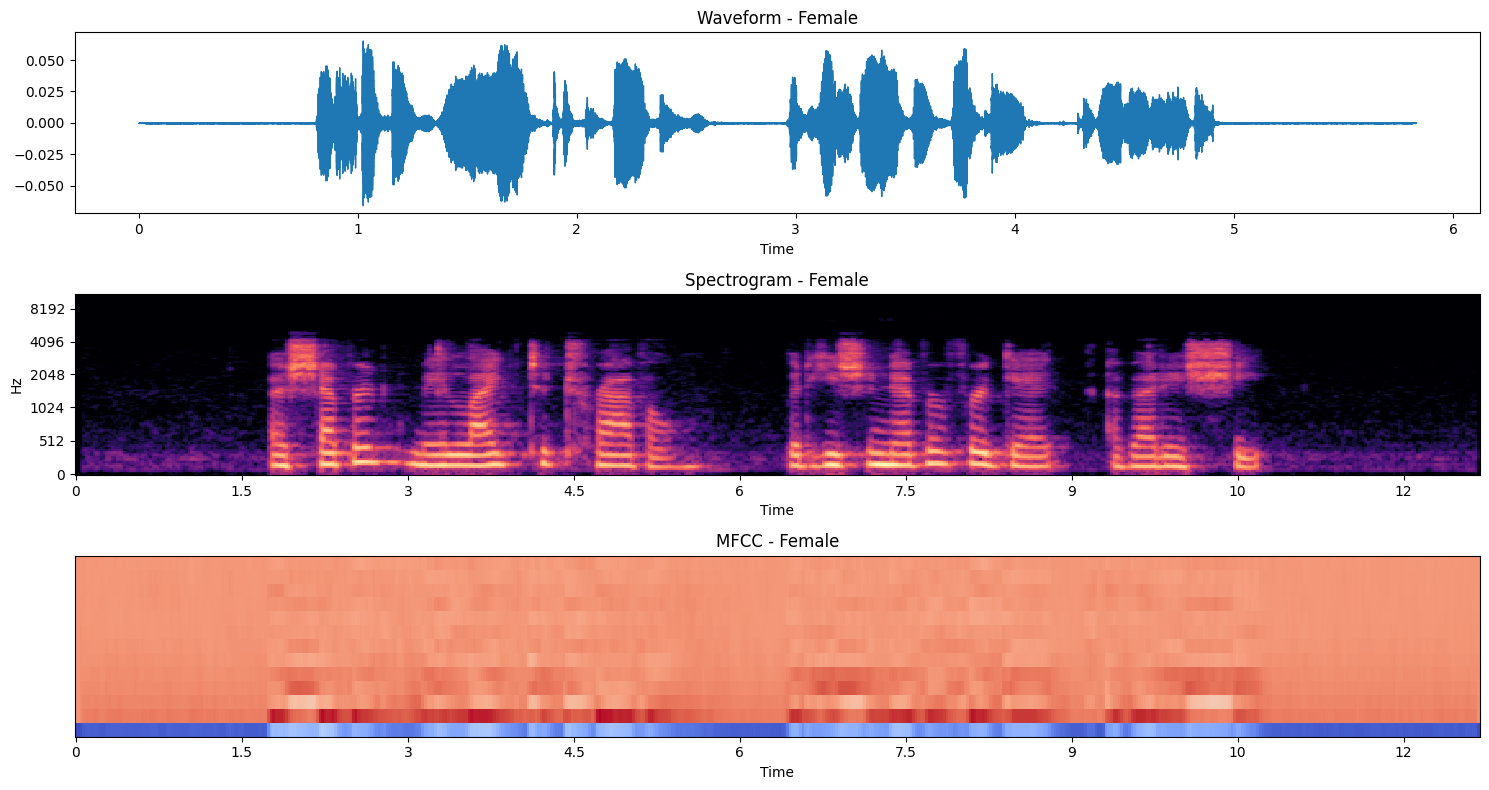

Plotting features for /content/cv-valid-train/cv-valid-train/sample-000013.mp3


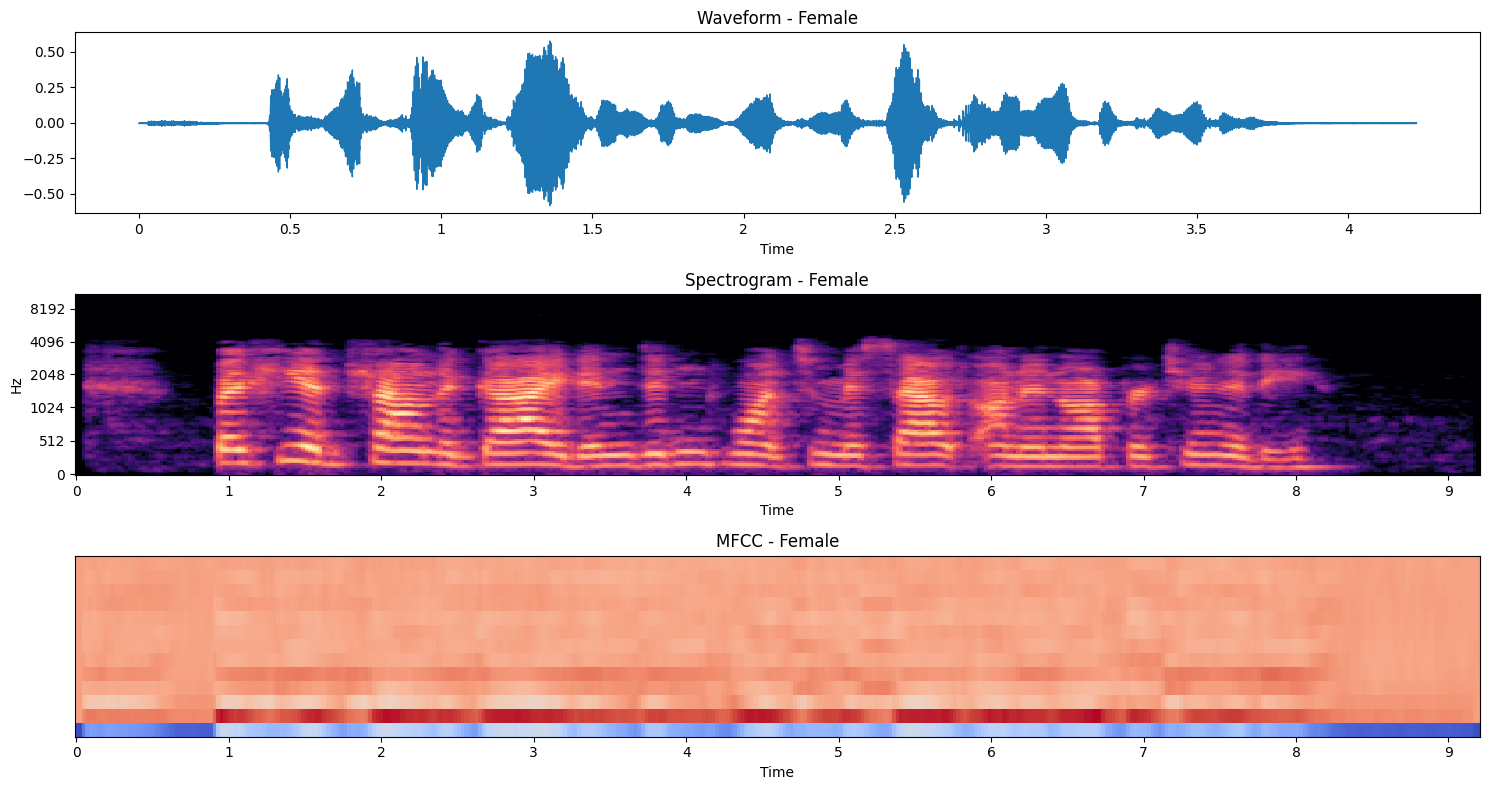

In [11]:
# Plot features for female files
for file in female_files:
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting features for {file_path}")
    plot_features(file_path, 'Female')

Plotting features for /content/cv-valid-train/cv-valid-train/sample-000008.mp3


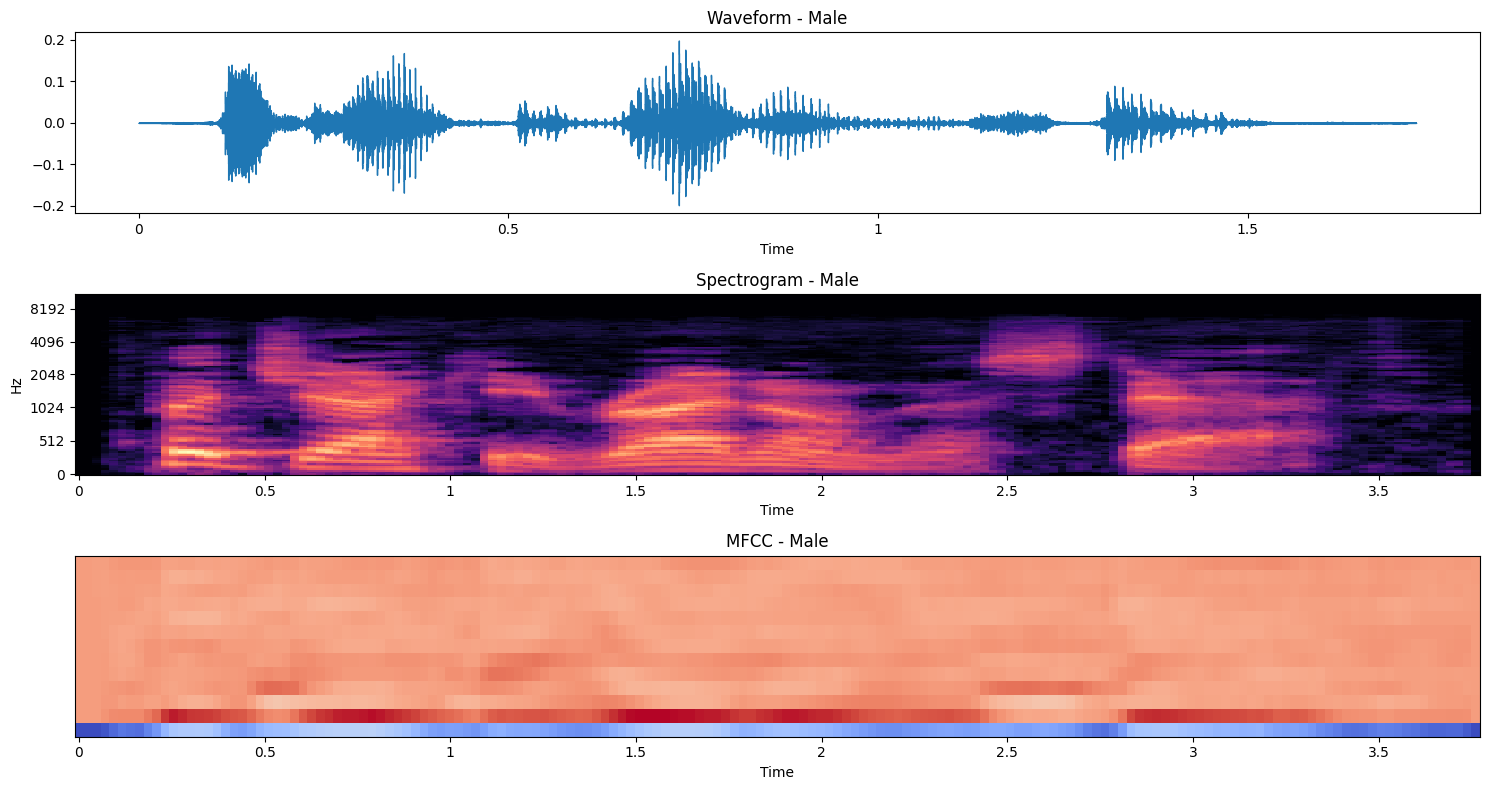

Plotting features for /content/cv-valid-train/cv-valid-train/sample-000014.mp3


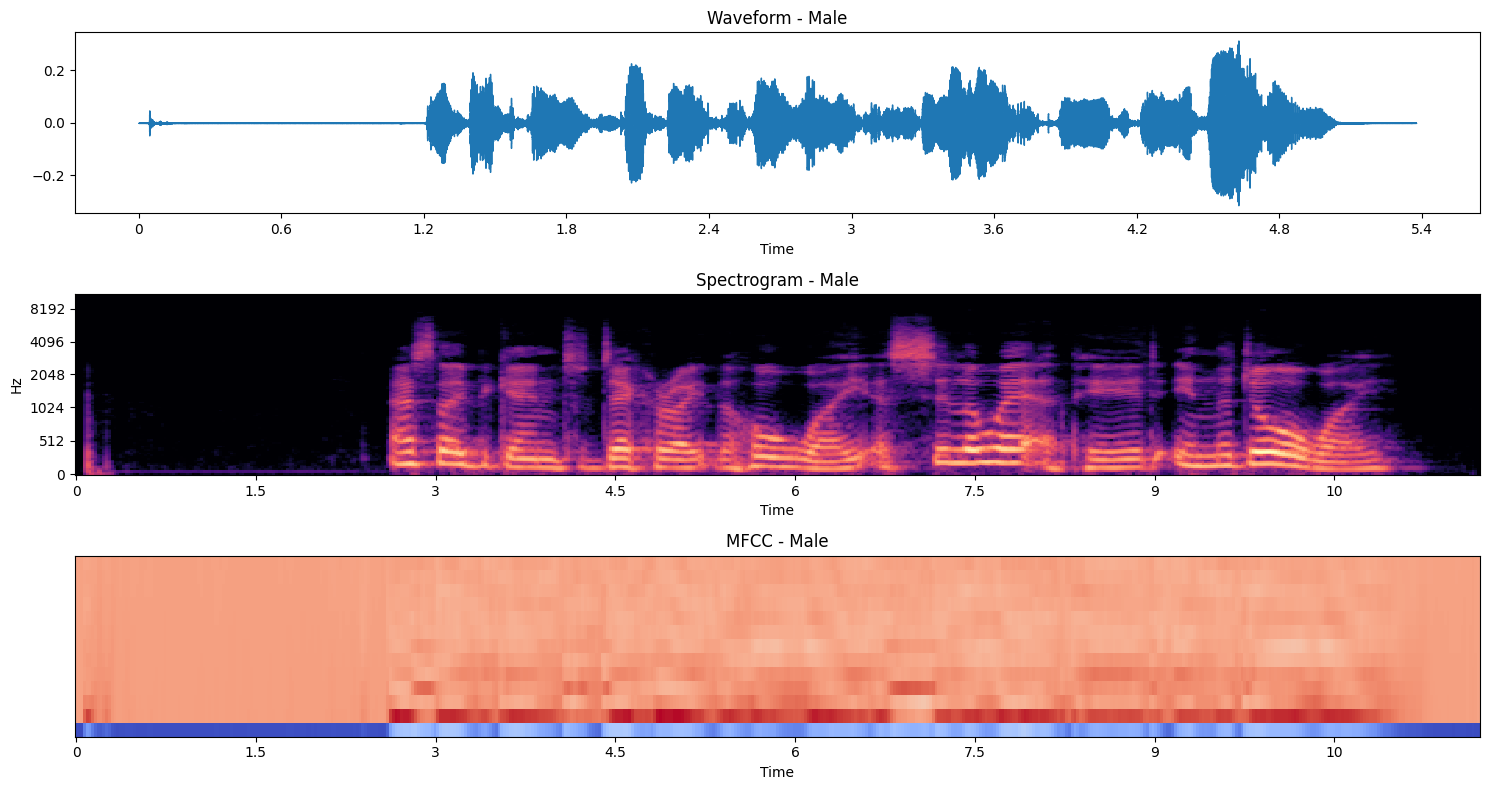

In [12]:
# Plot features for male files
for file in male_files:
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting features for {file_path}")
    plot_features(file_path, 'Male')

In [13]:
# Function to plot pitch contour using pyworld
import pyworld as pw

def plot_pitch_contour(file_path, gender, subplot_index):
    audio, sr = librosa.load(file_path, sr=None)
    audio = audio.astype('double')
    _f0, t = pw.dio(audio, sr)
    f0 = pw.stonemask(audio, _f0, t, sr)

    plt.subplot(2, 2, subplot_index)
    plt.plot(t, f0)
    plt.title(f'Pitch Contour - {gender}')
    plt.xlabel('Time(s)')
    plt.ylabel('Pitch (Hz)')

Plotting pitch contour for /content/cv-valid-train/cv-valid-train/sample-000005.mp3
Plotting pitch contour for /content/cv-valid-train/cv-valid-train/sample-000013.mp3


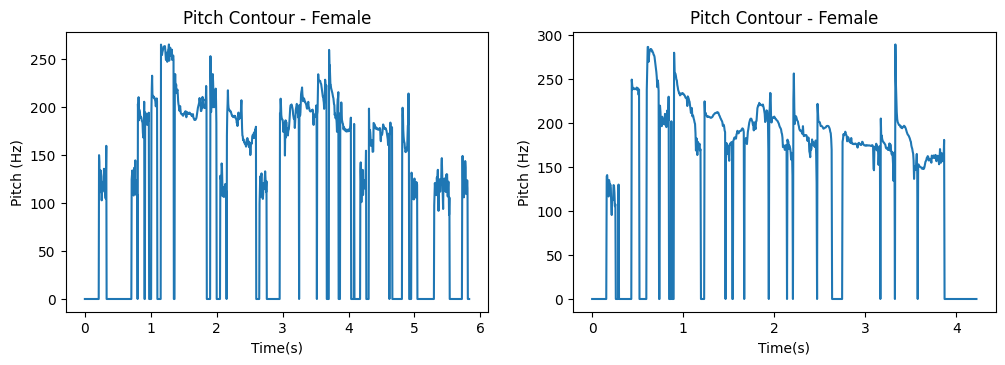

In [14]:
# Plot pitch contour for female files
plt.figure(figsize=(12, 8))
for i, file in enumerate(female_files, 1):
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting pitch contour for {file_path}")
    plot_pitch_contour(file_path, 'Female', i)

Plotting pitch contour for /content/cv-valid-train/cv-valid-train/sample-000008.mp3
Plotting pitch contour for /content/cv-valid-train/cv-valid-train/sample-000014.mp3


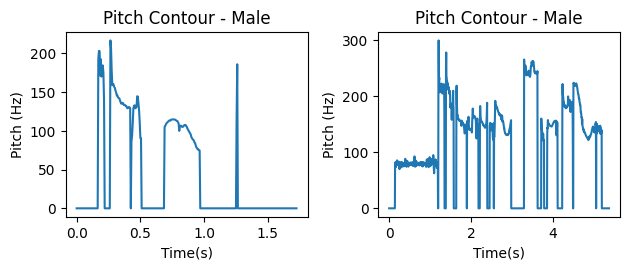

In [15]:
# Plot pitch contour for male files
for i, file in enumerate(male_files, 1):
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting pitch contour for {file_path}")
    plot_pitch_contour(file_path, 'Male', i + 2)
plt.tight_layout()
plt.show()

In [16]:
# Function to extract audio features
def extract_audio_features(file_path, num_features=28):
    try:
        audio, sr = librosa.load(file_path, sr=None)

        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=audio, n_mfcc=num_features)

        # Extract Chroma features
        chroma_features = librosa.feature.chroma_stft(y=audio, n_chroma=num_features)

        # Reduce either fmin or n_bands to address the Nyquist error
        contrast_features = librosa.feature.spectral_contrast(y=audio, n_bands=min(num_features, 6))

        # Concatenate all features
        all_features = np.concatenate((mfcc_features, chroma_features, contrast_features), axis=0)

        # Take the mean along the columns (axis=1)
        audio_features_mean = np.mean(all_features, axis=1)

        return audio_features_mean
    except Exception as e:
        print(f"Error processing file: {file_path}")
        print(e)
        return None

In [17]:
# Function to process a single row in dftrain
def process_row(row, feature_columns):
    file_name = row['filename'].split('/')[-1]
    file_path = os.path.join(audio_folder_path, file_name)

    if os.path.exists(file_path):
        audio_features_mean = extract_audio_features(file_path)

        if audio_features_mean is not None:
            for i, column in enumerate(feature_columns):
                dftrain.at[row.name, column] = audio_features_mean[i]
        else:
            print(f"Skipping file: {file_path}")

In [18]:
# Define the feature columns
audio_columns = [f'audio_feature_mean_{i}' for i in range(1, 29)]

# Add columns to store mean audio features
for column in audio_columns:
    dftrain[column] = None

# Extract mean audio features for the first 10,000 files in dftrain and add them as new columns using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_row, row, audio_columns) for _, row in dftrain.head(10000).iterrows()]

for future in futures:
    future.result()

dftrain.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration,audio_feature_mean_1,audio_feature_mean_2,...,audio_feature_mean_19,audio_feature_mean_20,audio_feature_mean_21,audio_feature_mean_22,audio_feature_mean_23,audio_feature_mean_24,audio_feature_mean_25,audio_feature_mean_26,audio_feature_mean_27,audio_feature_mean_28
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN,-624.648437,112.143115,...,-5.971159,-8.026086,-7.050545,-2.395903,-0.461247,-6.477646,-9.04836,-3.291855,-0.834687,-3.752578
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN,-465.450029,129.926537,...,-5.994767,-7.321055,2.136044,-0.519819,-0.091372,3.036302,2.391196,3.747133,-1.438698,-5.469978
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN,-418.681905,172.238835,...,-3.799932,-3.680292,-4.29386,-6.237994,-6.864157,-3.539646,-0.671063,-3.323203,-5.448705,-2.413586
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,-467.836003,110.09739,...,3.735575,-1.972156,-7.34892,-5.085369,1.642962,1.989853,-2.697836,-2.652054,0.340486,-0.831763
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,-349.42583,142.363606,...,-2.016612,7.757106,4.051686,-1.432403,-3.45612,2.198118,1.136141,3.889407,-1.568397,0.262695


In [19]:
# Removing rows where 'audio_feature_mean_1' is null
dftrain = dftrain[dftrain['audio_feature_mean_1'].notnull()]

# Removing rows where gender="other"
dftrain = dftrain[dftrain['gender'] != 'other']

# Drop unnecessary columns
columns_to_remove = ['filename', 'text', 'up_votes', 'down_votes', 'age', 'accent', 'duration']
dftrain = dftrain.drop(columns=columns_to_remove, errors='ignore')

In [20]:
# Label Encoding
label_encoder = LabelEncoder()
dftrain['gender_encoded'] = label_encoder.fit_transform(dftrain['gender'])

# Convert all columns to float except for 'gender'
dftrain[dftrain.columns.difference(['gender'])] = dftrain[dftrain.columns.difference(['gender'])].apply(pd.to_numeric, errors='coerce')

# Correlation Analysis
correlation_matrix = dftrain.drop(columns=['gender']).corr()
correlated_features = correlation_matrix[abs(correlation_matrix['gender_encoded']) < 0.1].index
dftrain_filtered = dftrain.drop(correlated_features, axis=1)

# Split the Data
X = dftrain_filtered.drop(columns=['gender'])
y = dftrain_filtered['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label Encoding
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

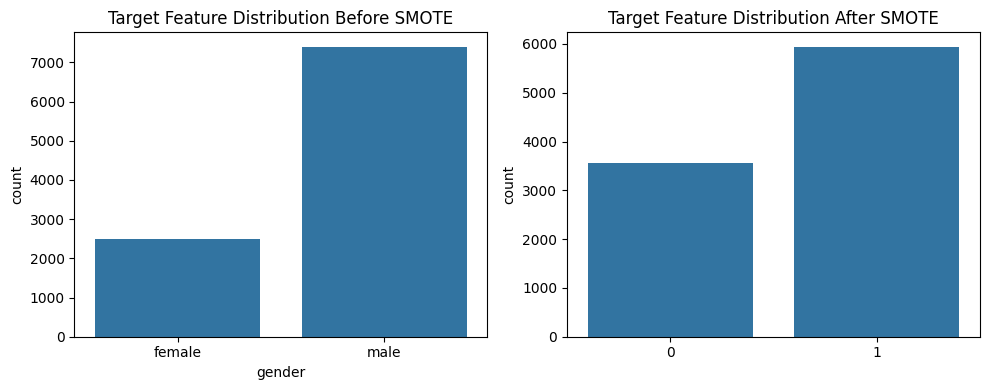

In [21]:
# SMOTE for balancing classes
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Min-Max Scaling
scaler = MinMaxScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Plot target feature distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='gender', data=dftrain_filtered)
plt.title('Target Feature Distribution Before SMOTE')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Target Feature Distribution After SMOTE')

plt.tight_layout()
plt.show()

Epoch 1/50
238/238 [==============================] - 2s 4ms/step - loss: 0.0344 - accuracy: 0.9868 - val_loss: 0.0511 - val_accuracy: 1.0000
Epoch 2/50
238/238 [==============================] - 1s 3ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 4.8064e-04 - val_accuracy: 1.0000
Epoch 3/50
238/238 [==============================] - 1s 3ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 2.0343e-05 - val_accuracy: 1.0000
Epoch 4/50
238/238 [==============================] - 1s 3ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 2.5149e-05 - val_accuracy: 1.0000
Epoch 5/50
238/238 [==============================] - 1s 3ms/step - loss: 4.2870e-04 - accuracy: 1.0000 - val_loss: 6.5973e-06 - val_accuracy: 1.0000
Epoch 6/50
238/238 [==============================] - 1s 3ms/step - loss: 3.6894e-04 - accuracy: 1.0000 - val_loss: 9.2593e-06 - val_accuracy: 1.0000
Epoch 7/50
238/238 [==============================] - 1s 3ms/step - loss: 3.0815e-04 - accuracy: 1.0000 - val_loss: 2.45

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       522
           1       1.00      1.00      1.00      1456

    accuracy                           1.00      1978
   macro avg       1.00      1.00      1.00      1978
weighted avg       1.00      1.00      1.00      1978



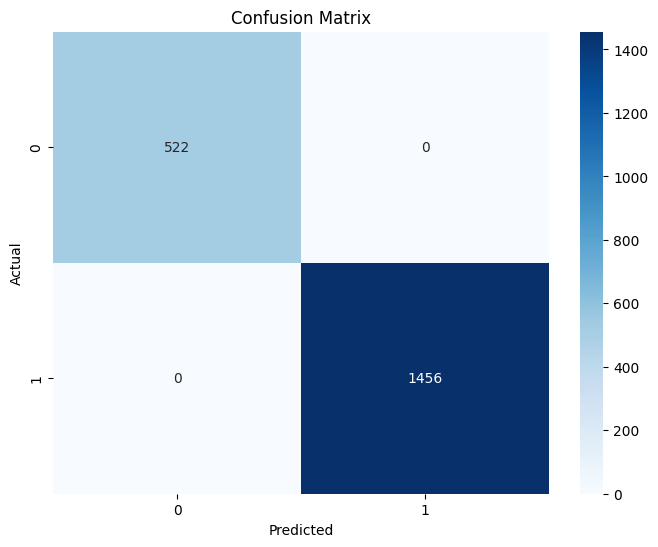

Accuracy: 1.0000


In [22]:
# Neural Network Model with Cross Validation
def create_model(input_shape, learning_rate=0.001):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Convert input shape
input_shape = (X_train_resampled_scaled.shape[1],)

# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_histories = []

for train_index, val_index in kf.split(X_train_resampled_scaled, y_train_resampled):
    X_fold_train, X_fold_val = X_train_resampled_scaled[train_index], X_train_resampled_scaled[val_index]
    y_fold_train, y_fold_val = y_train_resampled[train_index], y_train_resampled[val_index]

    model = create_model(input_shape)
    history = model.fit(X_fold_train, y_fold_train, epochs=50, batch_size=32, validation_data=(X_fold_val, y_fold_val))
    all_histories.append(history)

# Save the model
model.save('gender_classification_model.h5')

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_test_encoded, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")